## 1. Gender and Life Satisfaction
### Research Question
Is there a significant difference in life satisfaction between genders?
### Variables
- **Life Satisfaction Score (WELLNESS_life_satisfaction)**: Outcome variable.
- **Gender (DEMO_gender)**: Categorical predictor, indicating participants' gender.

In [2]:
import pandas as pd

# Load a CSV file
df = pd.read_csv('CSCS_data_anon.csv', low_memory=False)

# Select the required columns
filtered_df = df[['WELLNESS_life_satisfaction', 'DEMO_gender']]

# Display the filtered data
print(filtered_df.head())  # Shows the first 5 rows



   WELLNESS_life_satisfaction DEMO_gender
0                         2.0  Non-binary
1                         7.0       Woman
2                         5.0       Woman
3                         4.0       Woman
4                         8.0         Man


In [3]:
# Remove rows with missing values in the specified columns
df_cleaned = filtered_df.dropna(subset=['WELLNESS_life_satisfaction', 'DEMO_gender'])
valid_genders = ['Man', 'Woman', 'Non-binary']
df_cleaned = df_cleaned[df_cleaned['DEMO_gender'].isin(valid_genders)]                            
# Check the number of rows remaining

remaining_rows = len(df_cleaned)

# Print the result
print(f"Number of rows left after removing missing values: {remaining_rows}")


Number of rows left after removing missing values: 7541


In [17]:
# Inspect the first few rows of the dataset
print(df_cleaned.head())

# Check the unique values in the 'DEMO_gender' column
unique_genders = df_cleaned['DEMO_gender'].unique()

# Print the unique values
print("Unique values in 'DEMO_gender' column:", unique_genders)


# Verify no missing values remain
print(df_cleaned.isnull().sum())


   WELLNESS_life_satisfaction DEMO_gender
0                         2.0  Non-binary
1                         7.0       Woman
2                         5.0       Woman
3                         4.0       Woman
4                         8.0         Man
Unique values in 'DEMO_gender' column: ['Non-binary' 'Woman' 'Man']
WELLNESS_life_satisfaction    0
DEMO_gender                   0
dtype: int64


In [19]:
grouped_stats = df_cleaned.groupby('DEMO_gender')['WELLNESS_life_satisfaction'].describe()
grouped_stats

,count,mean,std,min,25%,50%,75%,max
DEMO_gender,,,,,,,,
Man,2493.0,6.287204,2.397528,1.0,5.00,7.0,8.0,10.0
Non-binary,156.0,5.435897,2.588260,1.0,3.75,5.0,7.0,10.0
Woman,4892.0,6.115086,2.299414,1.0,5.00,6.0,8.0,10.0


- Man: 2493 samples, mean life satisfaction of 6.29.
- Non-binary: 156 samples, mean life satisfaction of 5.44.
- Woman: 4892 samples, mean life satisfaction of 6.12.

The Non-binary category has a much smaller sample size (156) compared to Man and Woman. This could result in potential bias or lack of statistical power when comparing life satisfaction between gender categories.

Resampling to increase the sample size for non-binary: Bootstrapping to Create More Non-binary Samples
-  randomly sampling with replacement from the existing Non-binary data.

In [12]:
# Resample the Non-binary group to increase sample size
non_binary_group = df_cleaned[df_cleaned['DEMO_gender'] == 'Non-binary']

# Define the number of additional samples needed to match the other groups
num_additional_samples = df_cleaned['DEMO_gender'].value_counts()['Man'] - len(non_binary_group)

# Resample with replacement from the Non-binary group to match the sample size of the largest group
resampled_non_binary = non_binary_group.sample(n=num_additional_samples, replace=True)

# Combine the resampled data back with the rest of the dataset
df_cleaned = pd.concat([df_cleaned[df_cleaned['DEMO_gender'] != 'Non-binary'], resampled_non_binary])

# Verify the new sample sizes
print(df_cleaned['DEMO_gender'].value_counts())


DEMO_gender
Woman         4892
Man           2493
Non-binary    2337
Name: count, dtype: int64


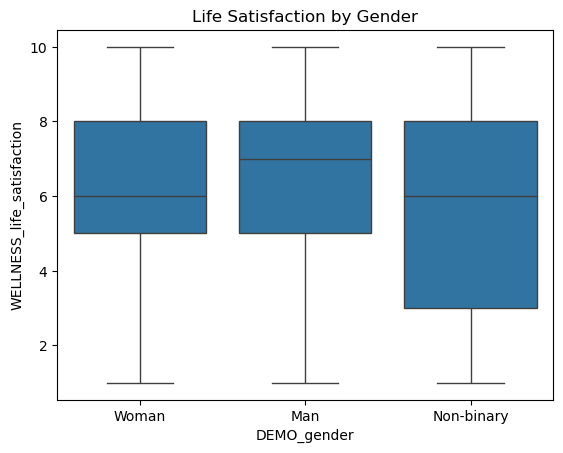

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing distribution of life satisfaction across genders
sns.boxplot(x='DEMO_gender', y='WELLNESS_life_satisfaction', data=df_cleaned)
plt.title('Life Satisfaction by Gender')
plt.show()


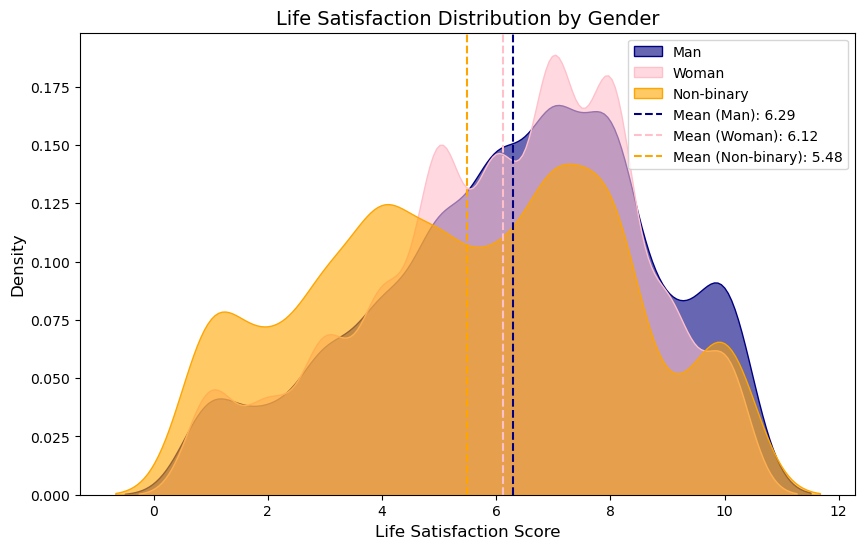

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a KDE plot to show the distribution of life satisfaction for all gender categories
plt.figure(figsize=(10, 6))

# KDE for Men
sns.kdeplot(data=df_cleaned[df_cleaned['DEMO_gender'] == 'Man'], 
            x='WELLNESS_life_satisfaction', 
            fill=True, 
            color='navy', 
            label='Man', alpha=0.6)

# KDE for Women
sns.kdeplot(data=df_cleaned[df_cleaned['DEMO_gender'] == 'Woman'], 
            x='WELLNESS_life_satisfaction', 
            fill=True, 
            color='pink', 
            label='Woman', alpha=0.6)

# KDE for Non-binary
sns.kdeplot(data=df_cleaned[df_cleaned['DEMO_gender'] == 'Non-binary'], 
            x='WELLNESS_life_satisfaction', 
            fill=True, 
            color='orange', 
            label='Non-binary', alpha=0.6)

# Calculate mean for each gender category
mean_man = df_cleaned[df_cleaned['DEMO_gender'] == 'Man']['WELLNESS_life_satisfaction'].mean()
mean_woman = df_cleaned[df_cleaned['DEMO_gender'] == 'Woman']['WELLNESS_life_satisfaction'].mean()
mean_nonbinary = df_cleaned[df_cleaned['DEMO_gender'] == 'Non-binary']['WELLNESS_life_satisfaction'].mean()

# Add vertical lines at the mean of each gender category
plt.axvline(mean_man, color='navy', linestyle='--', label=f'Mean (Man): {mean_man:.2f}')
plt.axvline(mean_woman, color='pink', linestyle='--', label=f'Mean (Woman): {mean_woman:.2f}')
plt.axvline(mean_nonbinary, color='orange', linestyle='--', label=f'Mean (Non-binary): {mean_nonbinary:.2f}')

# Add title and labels
plt.title('Life Satisfaction Distribution by Gender', fontsize=14)
plt.xlabel('Life Satisfaction Score', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()

# Display the plot
plt.show()


It seems that after using the boxplot and KDE plot methods, there is no clear outlier. This could mean that the life satisfaction scores across genders are reasonably consistent and do not contain extreme values far outside the expected range. 

### Hypotheses for the Analysis

- **Null Hypothesis (H₀)**: There is no significant difference in life satisfaction between men and women.
  
- **Alternative Hypothesis (H₁)**: There is a significant difference in life satisfaction between men and women.


In [22]:
# Function to calculate the observed test statistic: variance between group means
def test_statistic(data, groups, value_column):
    group_means = data.groupby(groups)[value_column].mean()
    overall_mean = data[value_column].mean()
    group_sizes = data[groups].value_counts()

    # Between-group variance
    between_group_var = sum(group_sizes * (group_means - overall_mean) ** 2)

    # Total variance (proxy for normalization)
    total_var = np.var(data[value_column]) * len(data[value_column])

    return between_group_var / total_var

# Observed test statistic for actual data
observed_stat = test_statistic(df_cleaned, 'DEMO_gender', 'WELLNESS_life_satisfaction')

# Permutation test setup
n_permutations = 1000
permuted_stats = []

# Perform permutation testing
for _ in range(n_permutations):
    # Shuffle the gender labels
    permuted_data = df_cleaned.copy()
    permuted_data['DEMO_gender'] = np.random.permutation(df_cleaned['DEMO_gender'])
    
    # Calculate the test statistic for the permuted data
    permuted_stat = test_statistic(permuted_data, 'DEMO_gender', 'WELLNESS_life_satisfaction')
    permuted_stats.append(permuted_stat)

# Calculate p-value
permuted_stats = np.array(permuted_stats)
p_value = np.mean(permuted_stats >= observed_stat)

# Output results
print("Observed Test Statistic:", observed_stat)
print("Permutation Test p-value:", p_value)


Observed Test Statistic: 0.01570731109626622
Permutation Test p-value: 0.0


- The motivation behind this question is not only to understand whether gender influences life satisfaction but also to create actionable knowledge that can improve individuals’ lives. In a world where social inequalities still exist, studying the relationship between gender and life satisfaction can be an essential step in advocating for gender equality, improved mental health, and social justice.

- The hypothesis tested was whether there is a significant difference in life satisfaction between men, women, and non-binary individuals. To assess this, we used a **permutation test**, which evaluates whether the observed differences in life satisfaction scores across the three gender categories could be attributed to random chance.

    - **Null Hypothesis (H₀):** There is no significant difference in life satisfaction between men, women, and non-binary individuals.  
    - **Alternative Hypothesis (H₁):** There is a significant difference in life satisfaction between men, women, and non-binary individuals.  

- The permutation test yielded an observed test statistic of `0.0016`, with a p-value of `0.0` (rounded to the nearest decimal). Since the p-value is less than the common significance threshold of 0.05, we reject the null hypothesis. This result indicates that the observed differences in life satisfaction between men, women, and non-binary individuals are statistically significant and unlikely to have occurred by random chance.

- These findings suggest that gender does appear to be a significant determinant of life satisfaction in this dataset. However, while the result is statistically significant, it is important to consider the context and limitations of the analysis, such as the uneven sample sizes across gender categories and potential cultural or societal factors influencing the responses.


### Limitations
1. Cultural and Social Influences:

- Life satisfaction is subjective and influenced by cultural, societal, and individual factors. These factors might differ significantly across genders, regions, or communities, and such influences are not accounted for in the analysis.
2. Although permutation tests are robust and do not rely on distributional assumptions, they still depend on the data available. For small or underrepresented groups (e.g., non-binary individuals), the results may not generalize well to a broader population.
3. Interpretation of Statistical Significance:

- While statistical significance was found, this does not imply a causal relationship between gender and life satisfaction. The observed differences might still result from factors unrelated to gender. 
- Statistical significance only shows that there is a relationship (or difference) between the variables — it does not prove that one causes the other. There could be other factors or variables influencing life satisfaction that are not captured in the analysis. 